# Lesson 3 (Covers Book Chapters 2 and 4)

## General Notes

* Chapter 4 deals with the technical underpinnings of deep learning while Chapter 3 focuses on AI ethics.


In [3]:
# Make sure that API key file and utils.py are uploaded to Colab session
import os
print(os.path.exists('./bing_api_key.py'))
print(os.path.exists('./utils.py'))

True
True


In [4]:
# Install packages
#!pip install fastai --upgrade
#!pip install nbdev
#!pip install azure-cognitiveservices-search-imagesearch

In [5]:
# Import required modules
from utils import *
from fastai.vision.widgets import *
from bing_api_key import key_1 # import API key, keep hidden

## Get Data via Bing Image Search API (repeat of code in Lesson 2 Notebook)

In [6]:
# Set API key
key = key_1

In [7]:
# Define bear categories for classification
bear_types = "grizzly", "black", "teddy"

# Download images of bear categories and place
# in respective directories
path = Path("bears")
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('content_url'))

In [8]:
# Return image file paths
fns = get_image_files(path)

# Check that all file names are images
failed = verify_images(fns)
failed

(#0) []

In [9]:
# Remove files that failed image verification
failed.map(Path.unlink)

(#0) []

## Create DataLoaders object

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

When you do `Resize(128)`, it turns each image into a 128x128 image by squishing it or stretching it.

Let's see examples of the images

In [11]:
dls = bears.dataloaders(path)

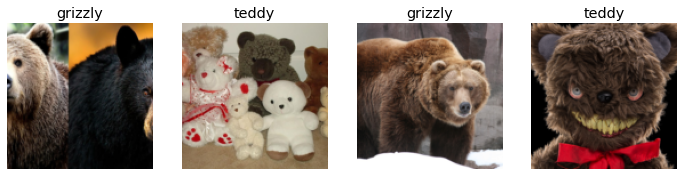

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

We need to have all images into a square before we can get it into the model. It needs to be the same size for each mini-batch.

[Question] What are the advantages of square vs. rectangular images?
* The advantage is simplicity.
* If you know that all of your images are of a specific aspect ratio, you can keep them that way.
* However, if some are tall and others wide, making them all square is the easiest approach.

Fastai defaults to grabbing the center of each image. In order to squish or stretch, you need to use a different transform.

Another approach is to make an identical copy of a `DataBlock` object by calling `bears.new()` method. Let's create another `DataBlock` object with a different set of transforms.

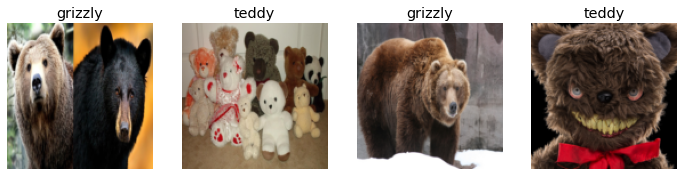

In [13]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
# Note that the bears below look much thinner!

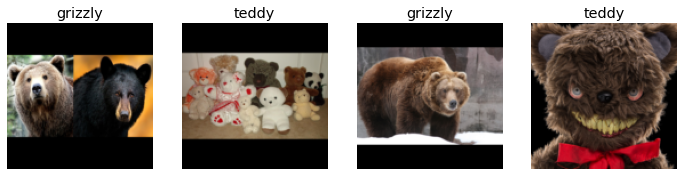

In [14]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

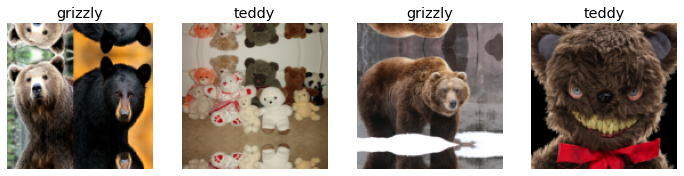

In [15]:
# Reflect padding instead of Zero padding
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='reflection'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

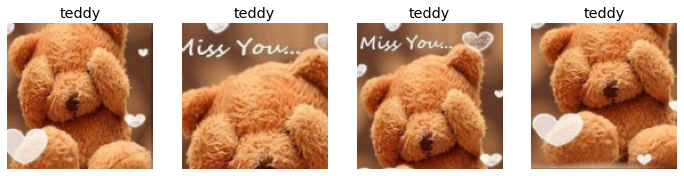

In [16]:
# This approach is good for overfitting, because you are not seeing the same
# image on each epoch

# min_scale = pick at least 30% of pixels in each image
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

This is a form of data augmentation.

Below, we use `aug_transforms` which returns a list of different augmentations.

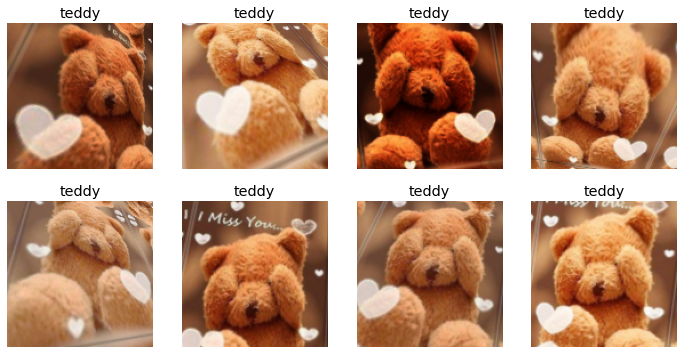

In [17]:
# Item transforms happen one image at a time.
# Batch transform happens to a whole mini-batch at a time. This is quick because
# it is transformed on the GPU.
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

[Question] How can we add different augmentations for train and validation sets?
* fastai will automatically avoid doing data augmentation on the validation set.
* aug_transforms are only applied to the training set.
* Exception is `RandomResizedCrop` (figure out later)
* We can write our own transformations using PyTorch.

## Training your model, and using it to clean your data

In [18]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

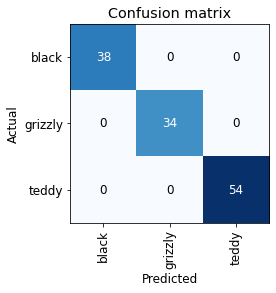

In [20]:
# Let's print out the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

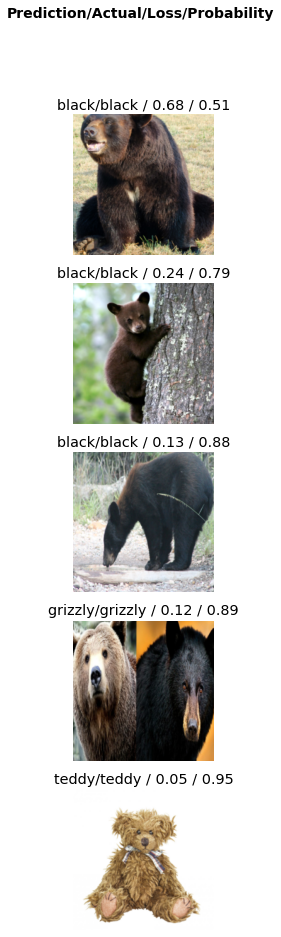

In [21]:
interp.plot_top_losses(5, nrows=5)

We didn't do much data cleaning before we created this model. We just verified that each image was valid. It is much easier to clean your data after you created a model.

`ImageClassifierCleaner` can be used to pick a category. Then it will list images in that set and pick the ones it is least confident about (where the loss is the worst). This is a great way to look through the data and find problems.

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [23]:
# Remove those that need to be deleted
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

# Move to correct folder
for idx, cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning model into an online application

### Using the model for inference

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

`.predict()` returns 3 probabilities representing the classes.

In [27]:
learn_inf.predict('/content/bears/black/00000001.jpg')

('black', tensor(0), tensor([9.9985e-01, 8.6264e-05, 6.3170e-05]))

In [28]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

### Create a Notebook app from the model
* Ipython widgets
* Voila

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

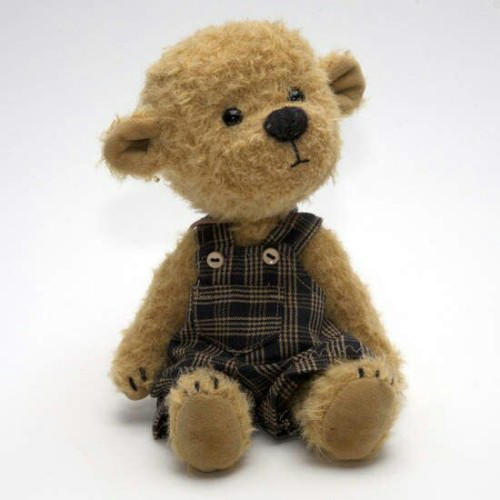

In [31]:
img = PILImage.create(btn_upload.data[-1])
img

We ca use an `Output` widget to display it:

In [32]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
  display(img.to_thumb(128,128))
out_pl

Output()

In [33]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Please choose an image'
lbl_pred

Label(value='Please choose an image')

In [34]:
btn_run = widgets.Button(description='Classify')

... and a *click event handler*, that is, a function that will be called when it's passed; we can just copy over the lines of code from above:

In [35]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl:
    display(img.to_thumb(128, 128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [36]:
btn_run.on_click(on_click_classify) 

In [37]:
# Vertical Box to install multiple widgets in
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning your notebook into a real app

In [38]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
